In [53]:
# Setup
import matplotlib
import numpy as np
import scipy as sp
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
import ggplot
%matplotlib inline

In [54]:
# Start an inference server

from venture.shortcuts import *
v = make_church_prime_ripl()
# x = Puma().make_church_prime_ripl()

In [55]:
# Forget everything

v.clear()

In [56]:
# Define a function for computing the HDI

def HDI_from_MCMC(posterior_samples, credible_mass):
    # Computes highest density interval from a sample of representative values,
    # estimated as the shortest credible interval
    # Takes Arguments posterior_samples (samples from posterior) and credible mass (normally .95)
    sorted_points = sorted(posterior_samples)
    ciIdxInc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    nCIs = len(sorted_points) - ciIdxInc
    ciWidth = [0]*nCIs
    for i in range(0, nCIs):
        ciWidth[i] = sorted_points[i + ciIdxInc] - sorted_points[i]
    HDImin = sorted_points[ciWidth.index(min(ciWidth))]
    HDImax = sorted_points[ciWidth.index(min(ciWidth))+ciIdxInc]
    return(HDImin, HDImax)


In [57]:
# # Specify model 1

# v.assume("offset_1", "(uniform_continuous -1 1)")
# v.assume("offset_2", "(uniform_continuous -1 1)")
# v.assume("linear", "(flip 0.5)")
# v.assume("beta_1", "(if linear (uniform_continuous -1 1) 0)")
# v.assume("quadratic", "(flip 0.5)")
# v.assume("beta_2", "(if quadratic (uniform_continuous -1 1) 0)")
# v.assume("noise_sd", "(exp (normal 0 2))")

# v.assume("f_1", "(lambda (x) (+ offset_1 (* beta_1 x) (* beta_2 x x)))")
# v.assume("f_2", "(lambda (x) (+ offset_2 (* beta_1 x) (* beta_2 x x)))")

# v.assume("cluster_membership", "(mem (lambda (index) (if (flip) 1 2)))")

# v.assume("f", "(lambda (x index) (if (eq (cluster_membership index) 1) (f_1 x) (f_2 x)))")

In [58]:
# Specify model 2

# v.assume("cluster_membership_crp", "(make_sym_dir_mult 1 2)")
v.assume("cluster_membership_crp", "(make_crp 0.3)")
v.assume("cluster_membership", "(mem (lambda (index) (cluster_membership_crp)))")
# v.assume("cluster_membership", "(mem (lambda (index) (if (flip) 0 1)))")

v.assume("offset", "(mem (lambda (cluster_index) (uniform_continuous -20 50)))")
v.assume("beta", "(normal 1.5 5)")
v.assume("noise_sd", "(+ 0.1 (exp (normal 0 2)))")

v.assume("f", "(lambda (x index) (+ (offset (cluster_membership index)) (* beta x)))")

'<procedure>'

In [59]:
v.sample('(cluster_membership 0)')

1

In [60]:
# Start inference

# v.start_continuous_inference()

In [61]:
# Create data

# X_1 = np.random.gamma(1, 1, 20)
# Y_1 = -0.4 + 0.5 * X_1 + 0.0 * X_1 * X_1
# Y_1 += 0.5 * np.random.randn(*X_1.shape)

# X_2 = np.random.gamma(1, 1, 10)
# Y_2 = +3 + 0.5 * X_2
# Y_2 += 0.5 * np.random.randn(*X_2.shape)

# X_3 = np.random.gamma(1, 1, 25)
# Y_3 = +0.7 + 0.5 * X_3
# Y_3 += 0.5 * np.random.randn(*X_3.shape)

# X = np.concatenate((X_1, X_2, X_3))
# Y = np.concatenate((Y_1, Y_2, Y_3))

In [62]:
# Read in CSV data

mydata = pd.read_csv("for_python.csv", header=0) #python starts counting at zero
X = mydata['mynewdata.FAI']
Y = mydata['mynewdata.AQ']


In [63]:
# Observe data

for index, (x, y) in enumerate(zip(X, Y)):
    v.observe("(normal (f %f %d) noise_sd)" % (x, index), y)
    index += 1

In [64]:
# v.sample("(cluster_membership 0)")

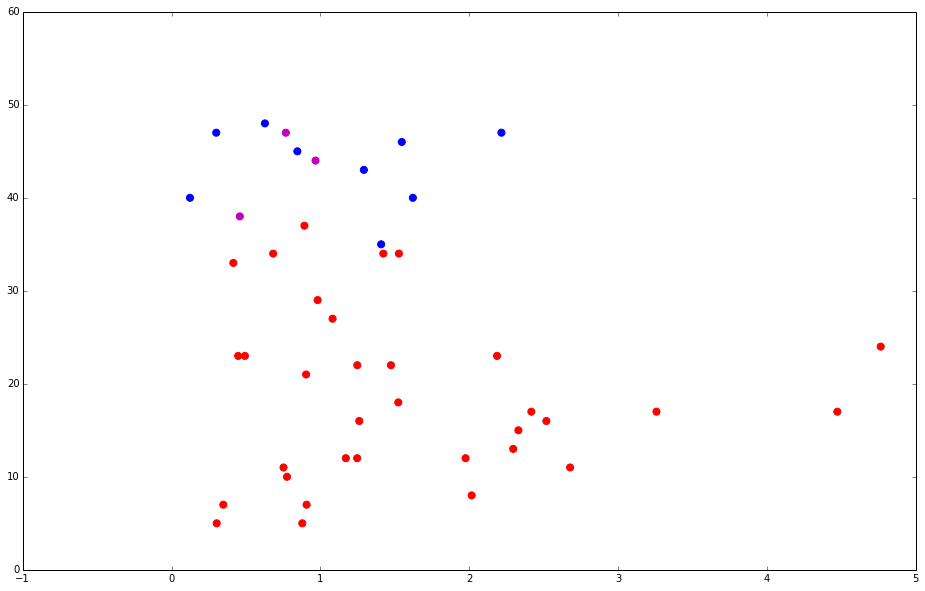

In [65]:
# Sample the parameters and draw a picture

# Only necessary if not running continuous inference
v.infer(5000)

# sample = v.sample("(list offset_1 offset_2 beta_1 beta_2 noise_sd)")
# offset_1 = sample[0]
# offset_2 = sample[1]
# beta_1 = sample[2]
# beta_2 = sample[3]
# noise_sd = sample[4]

# beta = v.sample("beta_1")
# offset_1 = v.sample("(offset 0)")
# offset_2 = v.sample("(offset 1)")

fig, ax = plt.subplots(figsize=(16, 10))
plt.clf()

cluster_memberships = v.sample('(list ' + ' '.join('(cluster_membership %d)' % index
                                                   for index in range(len(X))) + ')')
cluster_numbers = np.unique(cluster_memberships)
canonical_cluster_memberships = np.zeros(len(cluster_memberships))
for i, value in enumerate(cluster_numbers):
    canonical_cluster_memberships[cluster_memberships==value] = i
cluster_memberships = canonical_cluster_memberships

for (cluster_index, x, y) in zip(cluster_memberships, X, Y):
#     cluster_index = v.sample("(cluster_membership %d)" % index)
#     y_hat = v.sample("(f (0 0))")# % (x, index))
#     print(cluster_index)
    if cluster_index == 0:
        color = 'b'
    elif cluster_index == 1:
        color = 'r'
    elif cluster_index == 2:
        color = 'm'
    elif cluster_index == 3:
        color = 'c'
    else:
        color = 'k'
    plt.scatter(x, y, color=color, s=50)

# plt.scatter(X, Y, color='r', s=50)
# plt.scatter(X_2, Y_2, color='b', s=50)
# plot_x = np.linspace(min(X), max(X), 100)
# # plt.plot(plot_x, offset_1 + beta * plot_x, ls='-', color='g', lw=5)
# # plt.plot(plot_x, offset_2 + beta * plot_x, ls='-', color='g', lw=5)

# plt.show()

In [66]:
cluster_memberships

array([ 2.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  2.,  0.,  2.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  0.,  1.,  1.,  0.,  1.])

In [67]:
# # Sample in a loop to get distribution

# samples = list()

# for i in range(100):
    
# #     print(i)
    
#     v.infer(50)

#     sample = v.sample("(list offset beta_1 beta_2 noise_sd linear quadratic)")
#     offset = sample[0]
#     beta_1 = sample[1]
#     beta_2 = sample[2]
#     noise_sd = sample[3]
#     linear = sample[4]
#     quadratic = sample[5]
    
#     samples.append(linear)
    
# fig, ax = plt.subplots(figsize=(16, 10))
# plt.clf()

# plt.hist(samples)

# plt.show()

In [ ]:
# Stop inference

# v.stop_continuous_inference()

In [ ]:
# Sample the parameters and draw a picture

cluster_iterations = 1000
samples = list()

for _ in range(cluster_iterations):

    v.infer(1000)

    cluster_memberships = v.sample('(list ' + ' '.join('(cluster_membership %d)' % index
                                                       for index in range(len(X))) + ')')
    cluster_numbers = np.unique(cluster_memberships)
    
    samples.append(len(cluster_numbers))


# Plot using matplotlib - histograms for ggplot were unreliable due to strange decision making for binning

# Instead of using histogram, use bar chart after calling np.bincount - more flexible for graphic making
counts = np.bincount(samples)  


plt.clf()
fig, ax = plt.subplots(figsize=(10,16))
ax.bar(range(len(counts)), height=counts, width=1, align='center')
ax.set(xticks=range(10), xlim=[-1, 10])
plt.xlabel('Number of clusters')
plt.ylabel('Count')
# plt.savefig('cluster_num_hist.pdf') # must come before plt.show
plt.show()



In [ ]:
# Try to get a "trace" of number of clusters
df_cluster = pd.DataFrame(samples,  columns=['cluster_num_count'])

t = range(1,(cluster_iterations+1))

df_cluster['t'] = t

# Write this trace to file
import os.path


def next_cluster_file_name():
    num = 1
    while True:
        file_name = 'cluster_trace%d.csv' % num
        if not os.path.exists(file_name):
            return file_name
        num += 1


df_cluster.to_csv(next_cluster_file_name())

# print(df)

trace = ggplot.ggplot(ggplot.aes(x='t', y='cluster_num_count'), data=df_cluster)
trace = (trace + ggplot.geom_line()+ ggplot.theme_matplotlib() + 
ggplot.xlab("time where each point is a sample at 1000 transitions"))

print(trace)


In [ ]:
# Autocorrelation

ACF = []
for lag in range(1,(cluster_iterations/2+4)):
    result = []
    for row in range(lag,cluster_iterations): # Can't be more than the number of sample points taken
        result.append(df_cluster.ix[row,"cluster_num_count"])
    original = samples[:-lag]
    ACF.append(sp.stats.spearmanr(original,result))
    
# Returns a list of tuples of ACF values for lags in range

ACF = [x[0] for x in ACF]

s0 = pd.Series(ACF, name='ACF')

lagsize = range(1,cluster_iterations)
s1 = pd.Series(range(1,cluster_iterations), name='lagsize')

newdf = pd.DataFrame(s0, columns=["ACF"])
newdf['lagsize'] = s1

print(newdf)

x = ggplot.ggplot(ggplot.aes(x='lagsize', y='ACF'), data=newdf)
x = (x + ggplot.geom_bar(stat="bar")+ggplot.theme_matplotlib())

print(x)

# Effective sample size
last_k =[ n for n,i in enumerate(ACF) if i<0.05 ][0]
ACF_k = ACF[0:last_k]
print('Effective Sample Size')
print(cluster_iterations/(1+(2*sum(ACF_k))))


In [ ]:
# Find median of above
np.median(samples)

In [ ]:
# Sample the parameters and draw a picture

samples = list()
beta_iterations = 1000

for _ in range(beta_iterations):

    v.infer(1000)
    
    param_beta = v.sample('beta')

    samples.append(param_beta)
    
fig, ax = plt.subplots(figsize=(16, 10))
plt.clf()

plt.hist(samples)
plt.savefig("beta_posterior_hist.pdf")
plt.show()

In [ ]:
# ggplot
# Relies on list of samples generated from for loop above

df = pd.DataFrame(samples,  columns=['Beta_posterior'])


p = ggplot.ggplot(ggplot.aes(x='Beta_posterior'), data=df)
p = (p + ggplot.geom_histogram(fill='#0072B2') + ggplot.theme_matplotlib() + 
ggplot.xlab("Beta posterior distribution") + ggplot.ylab("Count"))



ggplot.ggsave(p, "beta_posterior_hist.pdf")
print(p)

In [ ]:
# Try to get a "trace" of beta values

df = pd.DataFrame(samples,  columns=['Beta_posterior'])
t = range(1,(beta_iterations+1))

df['t'] = t

# Write this trace to file

def next_beta_file_name():
    num = 1
    while True:
        file_name = 'beta_trace%d.csv' % num
        if not os.path.exists(file_name):
            return file_name
        num += 1


df.to_csv(next_beta_file_name())




trace = ggplot.ggplot(ggplot.aes(x='t', y='Beta_posterior'), data=df)
trace = (trace + ggplot.geom_line()+ ggplot.theme_matplotlib() + 
ggplot.xlab("time where each point is a sample at 1000 transitions"))

print(trace)



In [ ]:
# Sample 95% equal tails interval for beta values
a = np.percentile(samples, 2.5)
b = np.percentile(samples, 97.5)
print("95% equal tails interval for beta values")
print(a,b)

# Sample 95% HDI interval for beta values
j = HDI_from_MCMC(samples, .95)
print("95% HDI for beta values")
print(j)

# Sample 90% equal tails interval for beta values
a = np.percentile(samples, 5)
b = np.percentile(samples, 95)
print("90% equal tails interval for beta values")
print(a,b)

# Sample mean for beta values
c = np.mean(samples)
print("mean of beta values")
print(c)

# Median of beta values
z = np.median(samples)
print("Median of beta values")
print(z)

#Sample standard deviation for beta values
d = np.std(samples)
print("Standard deviation for beta values")
print(d)

# Count values less than 0
f = sum(i < 0 for i in samples)
f = f/1000.
print("posterior falling beneath 0")
print(f)

# Count values greater than 0
g = sum(i > 0 for i in samples)
g = g/1000.
print("posterior falling above 0")
print(g)


In [ ]:
# Autocorrelation

ACF = []
for lag in range(1,beta_iterations):
    result = []
    for row in range(lag,beta_iterations):
        result.append(df.ix[row,"Beta_posterior"])
    original = samples[:-lag]
    ACF.append(sp.stats.pearsonr(original,result))
    
# Returns a list of tuples of ACF values for lags in range

ACF = [x[0] for x in ACF]

s0 = pd.Series(ACF, name='ACF')

lagsize = range(1,501)
s1 = pd.Series(range(1,501), name='lagsize')

newdf = pd.DataFrame(s0, columns=["ACF"])
newdf['lagsize'] = s1

print(newdf)

# Effective sample size
last_k =[ n for n,i in enumerate(ACF) if i<0.05 ][0]
ACF_k = ACF[0:last_k]
print('Effective Sample Size')
print(beta_iterations/(1+(2*sum(ACF_k))))



x = ggplot.ggplot(ggplot.aes(x='lagsize', y='ACF'), data=newdf)
x = (x + ggplot.geom_bar(stat="bar")+ggplot.theme_matplotlib())

print(x)

In [ ]:
# Sample cluster assignments - make a list of all the assignments for each sample

samples = list()

for _ in range(1000):

    v.infer(1000)
    
    cluster_memberships = v.sample('(list ' + ' '.join('(cluster_membership %d)' % index
                                                   for index in range(len(X))) + ')')

    cluster_numbers = np.unique(cluster_memberships)

    canonical_cluster_memberships = np.zeros(len(cluster_memberships))
    
    for i, value in enumerate(cluster_numbers):
        canonical_cluster_memberships[cluster_memberships==value] = i
    
    cluster_memberships = canonical_cluster_memberships

    
    samples.append(cluster_memberships)
    
samples = np.array(samples)

# print(samples)

# print(samples.shape) # check to see whether array is correct shape

cluster_labels = np.unique(samples)

co_occurrence_matrix = np.zeros((samples.shape[1], samples.shape[1]))

for label in cluster_labels:
    co_occurrence_matrix += np.dot((samples.T == label) * 1, (samples == label) * 1)
    

# Reshape co-occurence_matrix by linkage
reshaped = sch.linkage(co_occurrence_matrix)
    
# print(co_occurrence_matrix)
# print(co_occurrence_matrix.shape)

# plt.clf()
# fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# ax.imshow(co_occurrence_matrix, interpolation='nearest') #interpolation changes fuzzyness. try 'none' or 'nearest'
# plt.show()

In [ ]:
co_occurrence_matrix = np.divide(co_occurrence_matrix, 10)

# Reshape co-occurence_matrix by linkage
linkage = sch.linkage(co_occurrence_matrix)
dendrogram_right = sch.dendrogram(linkage, orientation='right')
dendrogram = sch.dendrogram(linkage)
idx1 = dendrogram_right['leaves']
idx2 = dendrogram['leaves']
co_occurrence_matrix = co_occurrence_matrix[idx1,:]
co_occurrence_matrix = co_occurrence_matrix[:,idx2]

# Co-occurrence matrix figure

plt.clf()
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
map=ax.imshow(co_occurrence_matrix, interpolation='nearest')
plt.colorbar(map)
plt.savefig('co-occurrence.pdf') # this line has to come before plt.show
plt.show()

# print(reshaped)
# reshaped.shape

# plt.clf()
# fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
# ax.imshow(reshaped, interpolation='nearest') 
# plt.savefig('co-occurrence.pdf') # this line has to come before plt.show
# plt.show()
